In [1]:
import os
os.environ['autocnet_config'] = '/home/jlaura/autocnet_projects/demo.yml'

from autocnet_server.graph.graph import NetworkCandidateGraph

%pylab inline

/home/jlaura/anaconda3/envs/ct/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


## Network Candidate Graph Object

The AutoCNet project's (the library with the computer vision and photogrammetry logic that powers the AutoCNet_Server project) primary data structure is a candidate graph.  The AutoCNet Server (AS) project subclasses the CandidateGraph into a NetworkCandidateGraph to achieve a few goals:

- separate all of the data from the representation and support lazy access
- separate the analytics from the graph to support distributed computation
- support maximum scalability

Therefore, the NetworkCandidateGraph (NCG) acts like an AutoCNet candidate graph in that operations are performed on nodes (that represent images) and edges (that represent potential image overlap). The algorithms that exist in AutoCNet and have been used to research how to go about matching planetary images are exposed for use in the NCG.  When these algorithms are used though, the computation is pushed to a cluster job and the resultant data are stored in a database.  This allows the NCG to scale.

## Creating a CandidateGraph

A CandidateGraph is an object that represents the images (nodes) and overlap between those images (edges). With AutoCNet server, a candidate graph is backed by a series of PostGreSQL tables.  The candidate graph can represent all of the images in the database. This is achieved by using the `from_database()` method to load all of the data.  For example, 

`ncg = NetowrkCandidateGraph.from_database()`

Alternatively, the NetworkCandidateGraph can represent a subset of the images. This is accomplished by passing an SQL query in to the `from_database()` method.  See the documentation for an example how to accomplish this.

Finally, the NetworkCandidateGraph can be used to add images to an empty or exsiting database.  To do this, the `from_filelist()` class method used.  For example, 

`ncg = NetworkCandidateGraph.from_filelist(glob.glob('/scratch/jlaura/ctx_demo/cal/*.cub'))`


## Reading All Images

In [7]:
ncg = NetworkCandidateGraph.from_database()

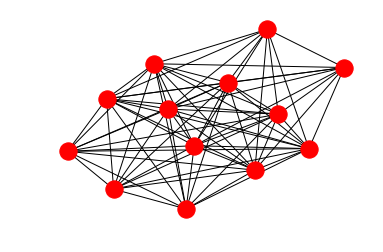

In [8]:
ncg.plot()

## SQL Queries for Database Creation
By default, the NCG will load **all** images in a project's `Images` table. This is not always desired (for example may P08 and P09 images are exceptionally noisy - dust storm?).  Therefore, it is possible to pass arbitrary queries to the `from_database` method.  The passed query (demonstrated below) are used as a subqueury inside of the spatial query that identifies overlap.  In practice this looks like:  `execute my custom query and get a subset of the data -> using the subset of the data, execute a spatial overlap query to build a graph object`.

In the example below, the NCG is built using all images that are **not** in a P orbit.

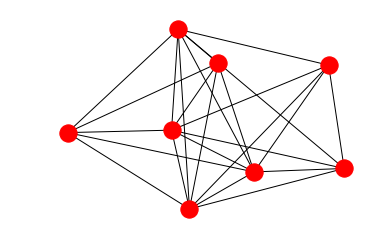

In [12]:
qs = "SELECT * FROM Images WHERE (split_part(path, '/', 6) ~ 'P[0-9]+_.+') = False"
ncg = NetworkCandidateGraph.from_database(query_string=qs)
ncg.plot()

### Spatial SubQuery

As another example, it is possible to execute a spatial subquery.  Here, image a use case where the entirety of the CTX data set has been processed through the ImageAdder.  A table with tens of thousands of CTX images and their associated footprints will be stored within a database.  This data store can be used as the source for different matching projects.  It may be that small region of interest should be processed.  The query below, selects those footprints that overlap the user supplied bounding polygon. (Note that for the demo that this notebook has been created the query will return no overlaps as the bounding polygon is outside of the demo extent.)

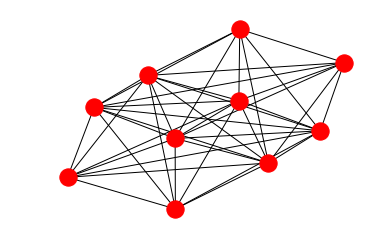

In [25]:
qs = "SELECT * FROM Images WHERE ST_INTERSECTS(footprint_latlon, ST_Polygon(ST_GeomFromText('LINESTRING(156 8, 156 8.5, 156.5 8.5, 156.5 8, 156 8)'),949900)) = TRUE"
ncg = NetworkCandidateGraph.from_database(query_string=qs)
ncg.plot()

## Adding New Images
As a final example, it is possible to add new images to an existing (or empty) project. While each image could be added one at a time, it is more efficient to pass a list of images to add.  Here, `glob` is used to grab all of the calibrated cubes (though uncalibrated PDS .IMG files could also be used) in a directory and those images are added to the candidate graph (and the backing database). All of the above example use a database loaded with the command below. 

Note that if an image already exists in the database, it will not be readded. To force an image to be readded, it should be removed from the database using some database tool (psql or pgadmin).

In [2]:
import glob
files = glob.glob('/scratch/jlaura/ctx_demo/cal/*.cub')

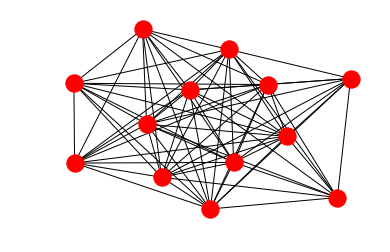

In [26]:
ncg = NetworkCandidateGraph.from_filelist(files)
ncg.plot()